In [1]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy import signal


from scipy.optimize import curve_fit
np.set_printoptions(threshold=sys.maxsize)
from skimage.io import imread, imshow
from math import sqrt,exp,floor


In [2]:
def spectrumCenter(image):  # Called for each laser line
    # Returns [x,y] of spectrum center
    image = cv2.fastNlMeansDenoising(image)
    edges = cv2.Canny(image, threshold1=100, threshold2=255) #(image, minValue, maxValue)
    print(edges.shape)
    pixels = np.where(edges >= 255)  # Array of coordinate arrays [ [y values], [x values] ]
    min_X = np.min(pixels[1])
    max_X = np.max(pixels[1])
    avg_X = round((min_X + max_X)/2) 
    min_Y = np.min(pixels[0])
    max_Y = np.max(pixels[0])
    avg_Y = (min_Y + max_Y)/2 
    height = max_Y - min_Y
    return avg_Y, height

def gauss(x, H, A, x0, sigma):
    # Returns y values for a gaussian 
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])      # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    return popt

# Operates on image to fitr a gaussian, Returns [FWHM, x_center]
def gaussianFitImage(image, row, height):
    # 2D Image Array
    row = round(row)                # round the row to closest integer pixel
    ran = round((height*.3)/2)      # average of middle 30%
    filtered = cv2.fastNlMeansDenoising(image)
    intensity = np.sum(filtered[(row-ran):(row+ran), 0:image.shape[1]], 0)/(ran*2)
    peak = np.where(intensity == np.max(intensity))[0][0]
    xdata = np.linspace((peak-15), (peak+15), 30)
    ydata = intensity[(peak-15):(peak+15)]
    H, A, x0, sigma = gauss_fit(xdata, ydata)   #
    FWHM = 2.355 * sigma # The expected relationship between std and FWHM is 2.355  https://en.wikipedia.org/wiki/Full_width_at_half_maximum
    return FWHM, x0

# Operates on 1D Data to Fit a Gaussian
def gaussianFitData(data):
    # 1D array of points
    peak = np.where(data == np.max(data))[0][0]
    xdata = np.linspace((peak-15), (peak+15), 30)
    ydata = intensity[(peak-15):(peak+15)]
    H, A, x0, sigma = gauss_fit(xdata, ydata)   #
    FWHM = 2.355 * sigma # The expected relationship between std and FWHM is 2.355  https://en.wikipedia.org/wiki/Full_width_at_half_maximum
    return FWHM, x0


# 2d PSF
def GaussianPSF(intensity, radius, imgShape):
    #Intensity Range 0-1
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = exp(((-distance((y,x),center)**2)/(2*(radius**2))))
    return intensity*base

def distance(point1,point2):
    return sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def closest(lst, K):      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx


# Laser Calbration Function
# Returns [avg_Y, FWHM: [], linearEq: [m, b]
def linearCalibration(laserImgs, wavelengths): # Expects ([img1, img2, img3], [num1, num2, num3])
    # Find the center of each laser line
    center_y1, height_1 =  spectrumCenter(laserImgs[0])
    center_y2, height_2 =  spectrumCenter(laserImgs[1])
    center_y3, height_3 =  spectrumCenter(laserImgs[2])

    # Average Y center is the row used for whole spectrum analysis
    avg_Y = round((center_y1 + center_y2 + center_y3)/3)

    # Find average FWHM and X Coord for each laser line
    FWHM_1, x_1 = gaussianFitImage(laserImgs[0], center_y1, height_1)
    FWHM_2, x_2 = gaussianFitImage(laserImgs[1], center_y2, height_2)
    FWHM_3, x_3 = gaussianFitImage(laserImgs[2], center_y3, height_3)
    print(x_1, x_2, x_3)

    # Group all FWHM values    
    FWHM = ([FWHM_1, FWHM_2, FWHM_3])

    # Fit Linear Function
    x = [x_1, x_2, x_3]
    y = [wavelengths[0], wavelengths[1], wavelengths[2]]
    linearEq = np.polyfit(x, y, 1)
    return avg_Y, FWHM, linearEq


In [3]:
# Used to make testing multiple trials easier
version = "Test10"

In [24]:
blue =  cv2.cvtColor(cv2.imread("images/"+version+"/405nm_laser.bmp"), cv2.COLOR_BGR2GRAY)
green = cv2.cvtColor(cv2.imread("images/"+version+"/532nm_laser.bmp"), cv2.COLOR_BGR2GRAY)
red =   cv2.cvtColor(cv2.imread("images/"+version+"/650nm_laser.bmp"), cv2.COLOR_BGR2GRAY)

avg_Y, FWHM, linearEq = linearCalibration([blue, green, red], [405,532,650])
print(FWHM)
print('Middle Row = ', avg_Y)

(1080, 1920)
Height  205
Middle  802.5
(1080, 1920)
Height  174
Middle  813.0
(1080, 1920)
Height  136
Middle  852.0
173.5309721534051 942.124385079524 1688.5774482137606
[10.512316154702605, 5.858690252920081, 4.963056107041145]
Middle Row =  822


(1080, 1920)
Height  136
Middle  852.0
The center of the gaussian fit is 1688.578113669188
The sigma of the gaussian fit is 2.1029484811607118
The FWHM of the gaussian fit is 4.952443673133476


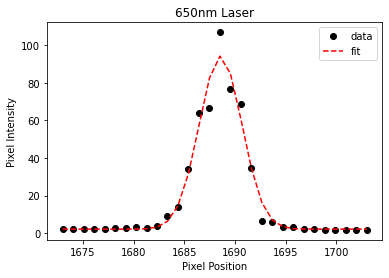

In [25]:
# Testing FWHM Calculations and Plot Generation
image = red
_y, _h = spectrumCenter(image)
_y = round(_y)
ran = round((_h*.3)/2)
intensity = np.sum(image[(_y-ran):(_y+ran), 0:image.shape[1]], 0)/(ran*2)
peak = np.where(intensity == np.max(intensity))[0][0]
xdata = np.linspace((peak-15), (peak+15), 30)
ydata = intensity[(peak-15):(peak+15)]

H, A, x0, _sigma = gauss_fit(xdata, ydata)   #
_FWHM = 2.355 * _sigma # The expected relationship between std and FWHM is 2.355  https://en.wikipedia.org/wiki/Full_width_at_half_maximum

print('The center of the gaussian fit is', x0)
print('The sigma of the gaussian fit is', np.abs(_sigma))
print('The FWHM of the gaussian fit is', np.abs(_FWHM))

plt.plot(xdata, ydata, 'ko', label='data')
plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, ydata)), '--r', label='fit')

plt.legend()
plt.title('650nm Laser')
plt.xlabel('Pixel Position')
plt.ylabel('Pixel Intensity')
plt.show()


In [26]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
# Using the FWHM We Know how much space each should take up
# image should be grey scale
def analyzeSpectrum(image, row, equation):
    row = round(row)
    intensity = np.sum(image[(row-100):(row+100), 0:image.shape[1]], 0)/200     # Create 1D Array using average intensity +-30 from center

    sigma = ((FWHM[0] + FWHM[1] + FWHM[2])/3)/2.355                             # Average Sigma Found While Calibrating

    # Convolve with PSF to smooth the curve and identify where peaks may be
    convolved = gaussian_filter1d(intensity, sigma)
    # Find Peaks in Convolved Image
    peaks, _ = find_peaks(convolved, distance=(sigma*2.355), height=15)

    if len(peaks >= 25):
        convolved = gaussian_filter1d(intensity, np.max(FWHM)/2.355)
        peaks, _ = find_peaks(convolved, distance=(sigma*2.355), height=15)

    # Deconvolve Image for Sharper Lines
    psf = GaussianPSF(255,sigma,[30, image.shape[1]])
    deconv_image = restoration.richardson_lucy(image[(row-15):(row+15), 0:image.shape[1]], psf, iterations=30)
    deconv = np.sum(deconv_image, 0)/30                                                                      # Create 1D Array using average intensity +-30 from center

    # Find x coords of max intensity in deconvolved image
    # Searches +-sigma from convolved peaks
    x_coords = []
    s = round(sigma)
    for peak in peaks:
        mx = np.where(intensity[(peak-s):(peak+s)] == np.max(intensity[(peak-s):(peak+s)]))[0][0] + (peak-s)
        x_coords.append(mx)

    # Create Array of Wavelengths
    wavelengths = []
    if len(equation)==2:
        for val in x_coords:
            wavelengths.append(val*equation[0]+equation[1])
    else:
        for val in x_coords:
            wavelength = pow(val,3)*equation[0] + pow(val,2)*equation[1] + val*equation[2] + equation[3]
            wavelengths.append(wavelength)
            print(wavelength)

    # Create Intensity Array
    intensities = []
    for i in peaks:
        intensities.append(convolved[i])
    np.diff(peaks)
    plt.title('Peaks Identified LED Spectrum')
    plt.xlabel('Pixel Position')
    plt.ylabel('Pixel Intensity')
    plt.plot(convolved)
    plt.plot(peaks, convolved[peaks], "x")
    plt.show()
    return x_coords[:50], wavelengths[:50], intensities[:50]

Peak Count  17
[ 173  359  667  951 1001 1026 1217 1230 1256 1276 1311 1349 1421 1504
 1536 1656 1801]
[405.80413928971933, 435.885665387407, 485.6980849470189, 531.6290172682195, 539.3919917450421, 543.9203935231886, 574.1636482558101, 576.2661205099496, 580.6327936531624, 584.5142808915737, 590.013054479323, 596.1587426068077, 607.8032043220416, 621.0649523866135, 626.5637259743629, 645.3242476266843, 669.2600855968874]


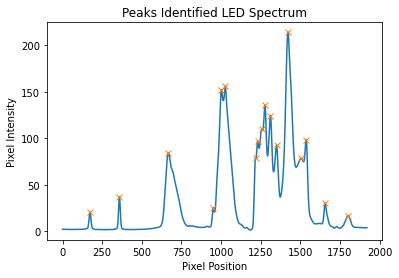

[173, 359, 667, 951, 999, 1027, 1214, 1227, 1254, 1278, 1312, 1350, 1422, 1504, 1538, 1654, 1802]
[405.80413928971933, 435.885665387407, 485.6980849470189, 531.6290172682195, 539.3919917450421, 543.9203935231886, 574.1636482558101, 576.2661205099496, 580.6327936531624, 584.5142808915737, 590.013054479323, 596.1587426068077, 607.8032043220416, 621.0649523866135, 626.5637259743629, 645.3242476266843, 669.2600855968874]


In [27]:
spectrum =  cv2.cvtColor(cv2.imread("images/"+version+"/cfl.bmp"), cv2.COLOR_BGR2GRAY)
x, wavelengths, intensity = analyzeSpectrum(spectrum, avg_Y, linearEq)

print(x)
print(wavelengths)


In [28]:
def nonLinearCalibration(spectrum):
    # set the to desired florescent wavelength values to observe
    peak_values = [404.65, 435.83, 546.07, 611.88]
    x_coords, wavelengths, intensity = analyzeSpectrum(spectrum, avg_Y, linearEq)

    # get postion of the wavelengths
    wavelengths_index = []

    wavelengths_index.append(closest(wavelengths, peak_values[0]))
    wavelengths_index.append(closest(wavelengths, peak_values[1]))
    wavelengths_index.append(closest(wavelengths, peak_values[2]))
    wavelengths_index.append(closest(wavelengths, peak_values[3]))
    
    print("Postion of the closest wavelength values")
    print(wavelengths_index)

    new_xCoords = []

    for i in wavelengths_index:
        new_xCoords.append(x_coords[i])
    
    print("Position of the updated pixel coordinates (x-values)")
    print(new_xCoords)

    return np.polyfit(new_xCoords, peak_values, 3)


Peak Count  17
[ 173  359  667  951 1001 1026 1217 1230 1256 1276 1311 1349 1421 1504
 1536 1656 1801]
[405.80413928971933, 435.885665387407, 485.6980849470189, 531.6290172682195, 539.3919917450421, 543.9203935231886, 574.1636482558101, 576.2661205099496, 580.6327936531624, 584.5142808915737, 590.013054479323, 596.1587426068077, 607.8032043220416, 621.0649523866135, 626.5637259743629, 645.3242476266843, 669.2600855968874]


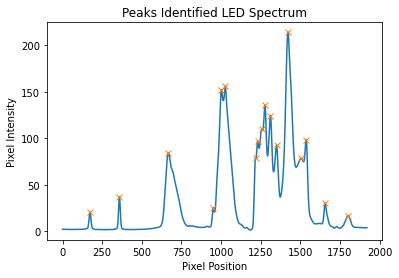

Postion of the closest wavelength values
[0, 1, 5, 12]
Position of the updated pixel coordinates (x-values)
[173, 359, 1027, 1422]
[ 3.63000966e-09 -8.70891397e-06  1.71465620e-01  3.75228302e+02]


In [29]:
ne = nonLinearCalibration(spectrum)
print(ne)


Peak Count  17
404.6499999999997
435.83
486.79854273464457
533.5378739085282
541.4500817059363
546.0699999999999
577.0471727398008
579.2107539266899
583.7094259120147
587.7142874763708
593.398184189957
599.766077969308
611.8799999999999
625.7624458584771
631.5481439976645
651.4326591463978
677.1705907953119
[ 173  359  667  951 1001 1026 1217 1230 1256 1276 1311 1349 1421 1504
 1536 1656 1801]
[404.6499999999997, 435.83, 486.79854273464457, 533.5378739085282, 541.4500817059363, 546.0699999999999, 577.0471727398008, 579.2107539266899, 583.7094259120147, 587.7142874763708, 593.398184189957, 599.766077969308, 611.8799999999999, 625.7624458584771, 631.5481439976645, 651.4326591463978, 677.1705907953119]


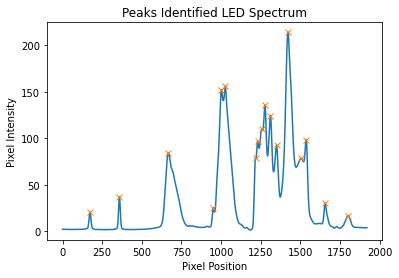

[404.6499999999997, 435.83, 486.79854273464457, 533.5378739085282, 541.4500817059363, 546.0699999999999, 577.0471727398008, 579.2107539266899, 583.7094259120147, 587.7142874763708, 593.398184189957, 599.766077969308, 611.8799999999999, 625.7624458584771, 631.5481439976645, 651.4326591463978, 677.1705907953119]
[20.444890087435496, 36.936342361300916, 84.06275525492401, 25.369010226666656, 152.17254729887946, 155.80857499143062, 78.81402933678369, 96.68538245367145, 109.51316570540587, 135.27860126228296, 124.25795436655643, 92.52168415456592, 213.84176782074783, 78.28235406272836, 98.60633859254499, 30.271033471500527, 16.702955510943525]
213.84176782074783


In [30]:
led =  cv2.cvtColor(cv2.imread("images/"+version+"/led (1).bmp"), cv2.COLOR_BGR2GRAY)
 
_1, _2, _3 = analyzeSpectrum(led, avg_Y, ne)
print (_2)
print (_3)
print (np.max(_3))

1920


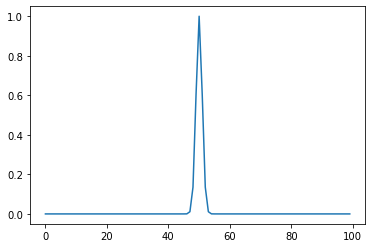

In [31]:
print(spectrum.shape[1])
H = 0
A = 1
sigma = 1
span= 100   
x0 = span/2

# Gaussian cannot have edge zeros
x = np.arange(span)
g = gauss(x, H, A, x0, sigma)
plt.plot(g)
plt.show()



[]


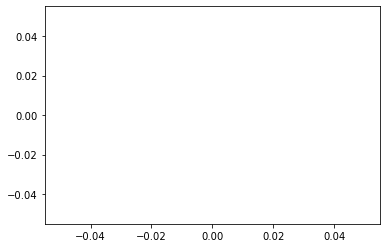

In [32]:
aconvolved = signal.convolve(intensity, g)

deconv = signal.deconvolve(intensity, g )[0]
plt.figure()
plt.plot(deconv, 'r')
plt.draw()
peaks, _ = find_peaks(deconv, distance=(2.355*2.355), height=40)
wavelengths = peaks*linearEq[0]+linearEq[1]
# print(peaks)
# print(wavelengths)
print(deconv)

In [33]:
a = intensity
b = np.array([0,0,0,0,1,2,1,0,0,0,0,0])

aconvolved = signal.convolve(a, b)
adeconvolved = signal.deconvolve(aconvolved, b)[0]

plt.figure()
plt.plot(a, np.sin(a), 'g')
plt.plot(a, adeconvolved, 'b')
plt.draw()


ValueError: BUG: filter coefficient a[0] == 0 not supported yet

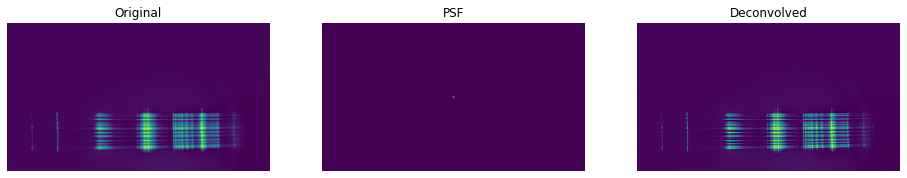

In [59]:
# Point Spread Function Example
# https://svi.nl/Huygens-Deconvolution
# We could edit this PSF to match our systems.
spectrumImg = cv2.imread('images/Test3/cfl.bmp')

img = color.rgb2gray(spectrumImg)

sigma = ((FWHM[0] + FWHM[1] + FWHM[2])/3)/2.355                             # Average Sigma Found While Calibrating

psf = GaussianPSF(255,sigma,img.shape)

#convolved = conv2(img, psf, 'same')
#deconvolved, _= restoration.unsupervised_wiener(img, psf)
row = round(avg_Y)
deconvolved = restoration.richardson_lucy(img, psf, iterations=30)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 10),
                       sharex=True, sharey=True)


ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(psf)
ax[1].axis('off')
ax[1].set_title('PSF')

ax[2].imshow(deconvolved)
ax[2].axis('off')
ax[2].set_title('Deconvolved')


plt.show()

184


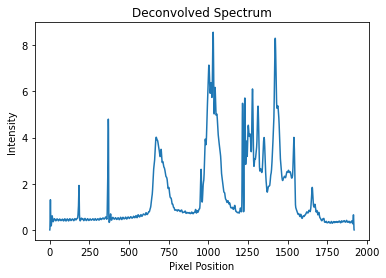

In [45]:
deconv = np.sum(deconvolved, 0)/30                                                                      # Create 1D Array using average intensity +-30 from center
plt.title('Deconvolved Spectrum')
plt.xlabel('Pixel Position')
plt.ylabel('Intensity')

plt.plot(deconv)


396.96935510412044
0.15458256519089927
[]
[]


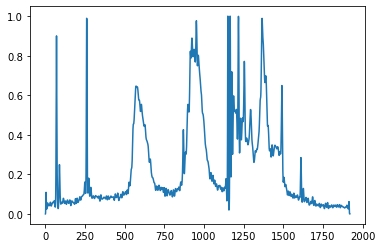

 1.18077596e-01, 1.16613263e-01, 1.12232166e-01,
       1.06488565e-01, 1.00579348e-01, 9.48966184e-02, 8.99194594e-02,
       8.66973453e-02, 8.62810449e-02, 8.90704343e-02, 9.46957569e-02,
       1.02195995e-01, 1.10221314e-01, 1.17179134e-01, 1.21391565e-01,
       1.21521273e-01, 1.17298779e-01, 1.09948629e-01, 1.01715556e-01,
       9.48157170e-02, 9.06921611e-02, 8.99549920e-02, 9.26836174e-02,
       9.85889268e-02, 1.06815414e-01, 1.15692608e-01, 1.23085351e-01,
       1.27417139e-01, 1.28395808e-01, 1.26724226e-01, 1.23408173e-01,
       1.19459667e-01, 1.15875469e-01, 1.13497786e-01, 1.12815879e-01,
       1.13922291e-01, 1.16579139e-01, 1.20224133e-01, 1.23925707e-01,
       1.26532405e-01, 1.27199430e-01, 1.25999581e-01, 1.24003607e-01,
       1.22674067e-01, 1.23108078e-01, 1.25619204e-01, 1.29613734e-01,
       1.33609730e-01, 1.35660871e-01, 1.34430391e-01, 1.30193823e-01,
       1.24668441e-01, 1.19911994e-01, 1.17481063e-01, 1.18243742e-01,
       1.22429238e-01, 1.296

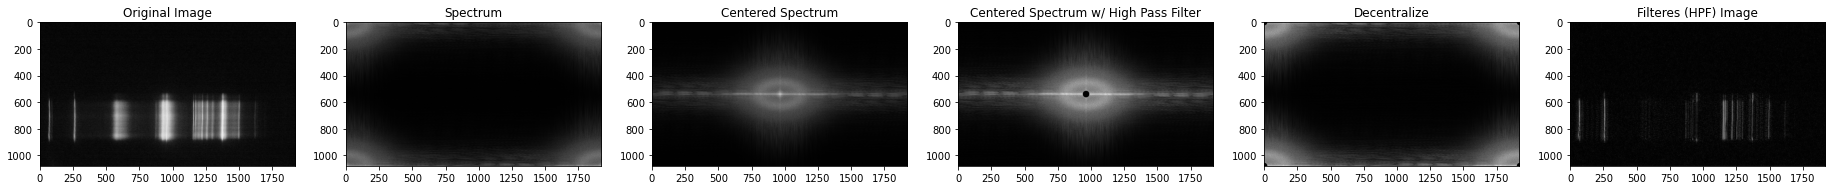

In [11]:
def HighPassFilter(radius,imgShape):
    # Creates an empty circle/mask with a given radius
    # This circle can be used to mask out frequncies equal to or lower than the radius
    base = np.ones(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < radius:
                base[y,x] = 0
    return base


plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

spectrum = np.fft.fft2(deconvolved) #Get Image Frequency Spectrum
center = np.fft.fftshift(spectrum) #Shift 0 frequency to the center 
highPassCenter = center * HighPassFilter(25,img.shape) #Apply High Pass Filter/Masking Function
highPass = np.fft.ifftshift(highPassCenter)  #Inverse shift to move 0 frequency back to original location
inverse_HighPass = np.fft.ifft2(highPass) # Inverse of step 1 to get image info back from frequency 


plt.subplot(161), plt.imshow(img, "gray"), plt.title("Original Image")
plt.subplot(162), plt.imshow(np.log(1+np.abs(spectrum)), "gray"), plt.title("Spectrum")
plt.subplot(163), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Centered Spectrum")
plt.subplot(164), plt.imshow(np.log(1+np.abs(highPassCenter)), "gray"), plt.title("Centered Spectrum w/ High Pass Filter")
plt.subplot(165), plt.imshow(np.log(1+np.abs(highPass)), "gray"), plt.title("Decentralize")
plt.subplot(166), plt.imshow(np.abs(inverse_HighPass), "gray"), plt.title("Filteres (HPF) Image")

plt.show()


NameError: name 'window' is not defined